**Author**: Marie-Jade Marcil
<br>
**Student ID**: 186239
<br>
**Date**: November 26, 2024
<br>
<br>
**Objective**: This notebook presents the evaluation of different transfer learning models, including DenseNet121 and VGG16, for the task of soil classification. The aim is to **determine which model performs best in distinguishing between four types of soils**: Alluvial Soil, Black Soil, Clay Soil, and Red Soil.


# Libraries and Modules

In [1]:
import json
import math
import os
import random

import cv2
from PIL import Image
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import cohen_kappa_score, accuracy_score


import tensorflow as tf
from tqdm import tqdm

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Importing data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

train_dir = '/content/drive/MyDrive/Soil/Dataset/Train'
test_dir = '/content/drive/MyDrive/Soil/Dataset/Test'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Labels and Image size

In [4]:
labels = ['Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil']
image_size = 224

# Visualising Data

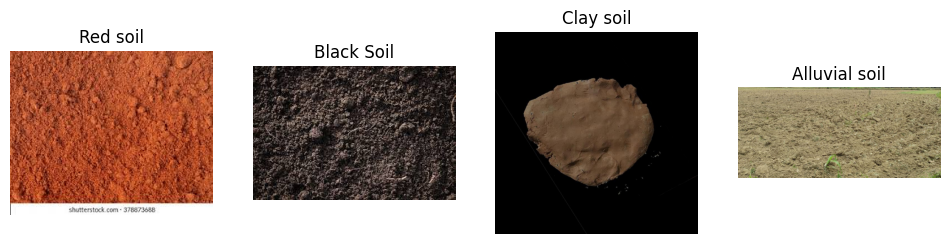

In [5]:
import os
import cv2
import matplotlib.pyplot as plt
import random

classes = os.listdir(train_dir)

num_samples = 8
sample_images = []

# Collect random sample images from each class
for label in classes:
    label_dir = os.path.join(train_dir, label)
    images = os.listdir(label_dir)

    sample_image = os.path.join(label_dir, random.choice(images))  # Randomly select an image from the class
    sample_images.append((sample_image, label))


plt.figure(figsize=(12, 6))
for i, (image_path, label) in enumerate(sample_images[:num_samples]):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Change color to RGB (from BGR)
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.show()


# Preprocessing

## Resize Images

The images need to be resize to 224x224 for the DenseNet121 and then create a single numpy array to hold the data.

In [ ]:
target_size = (224, 224)

## Noise Reduction

---

**Apply noise reduction beforeresizing and normalization to ensures the image is clean and standardized before resizing to the input size.**

---



### Gaussian Blur

* Smoothens the image by averaging pixel intensities using a Gaussian kernel.

* Suitable for reducing random noise while preserving edges.

In [ ]:
def gaussian_denoise(image):

    denoised = cv2.GaussianBlur(image, (5, 5), 0)

    return denoised

### Median Blur

* Replaces each pixel's intensity with the median of its neighboring pixels.

* Worls well for salt-and-pepper noise.

In [ ]:
def median_denoise(image):

    denoised = cv2.medianBlur(image, 5)

    return denoised

### Bilateral Filter

* Reduces noise while preserving edges.

* Particularly useful for images with strong textures.

**Parameters**

1.   ***d***: Diameter of each pixel neighborhood.
2.   ***sigmaColor***: Value of sigma  in the color space. The greater the value, the colors farther to each other will start to get mixed.

3. ***sigmaSpace***: Value of sigma  in the coordinate space. The greater its value, the more further pixels will mix together, given that their colors lie within the sigmaColor range

In [ ]:
def bilateral_denoise(image):
    # cv2.bilateralFilter(image, d, sigmaColor, sigmaSpace)
    denoised = cv2.bilateralFilter(image, 9, 75, 75)

    return denoised

### Non-Local Means Denoising

* Removes noise by averaging similar patches across the images.

* Effective for strong noise.

In [ ]:
# Convert to grayscale if the image is colored
def grayscale_image(image):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    return gray

def nl_means_denoise(image):

    gray = grayscale_image(image)
    denoised = cv2.fastNlMeansDenoising(gray, None, h=10, templateWindowSize=7, searchWindowSize=21)

    return cv2.cvtColor(denoised, cv2.COLOR_GRAY2RGB)

### PSNR Calculation

The formula for calculating PSNR is given by:

$$
PSNR = 10 \cdot \log_{10}\left(\frac{MAX^2}{MSE}\right)
$$

Where:
- \( MAX \): Maximum possible pixel value (e.g., 255 for 8-bit images).
- \( MSE \): Mean Squared Error between the original and reconstructed image.


In [ ]:
import numpy as np

def calculate_psnr(original, denoised):

    mse = np.mean((original - denoised) ** 2) # Ensure the images have the same dimensions

    if mse == 0:  # No noise in the image

        return float('inf')

    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))

    return psnr

### Interpreting PSNR Values

* **Low PSNR** (< 20 dB):
  * Poor quality denoising. The denoised
  image still has significant noise or distortion.

* **Moderate PSNR** (20–30 dB):
  * Acceptable quality denoising, but some noise or artifacts may remain.

* **High PSNR** (> 30 dB):
  * High-quality denoising with minimal
  noise and distortion.

* **Very High PSNR** (> 40 dB):
  * Almost perfect denoising.

PSNR after Gaussian denoising: 30.991732807312864
PSNR after Median denoising: 31.02062335266457
PSNR after Bilateral denoising: 32.09608974351729
PSNR after Non-Local Means denoising: 31.064391302637013


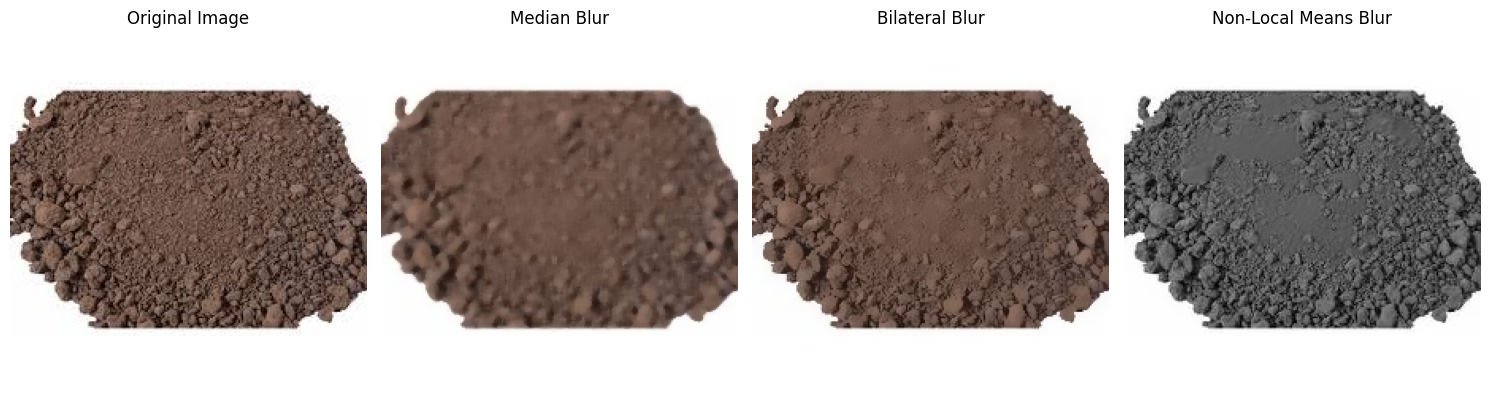

In [ ]:
image_path = "/content/drive/MyDrive/Soil/Dataset/Test/Black Soil/Black_34.jpg"
original_image = cv2.imread(image_path)

# Denoise the image
gaussian_image = gaussian_denoise(original_image)

median_blur = median_denoise(original_image)

bilateral_blur = bilateral_denoise(original_image)

nl_means_blur = nl_means_denoise(original_image)

# Calculate PSNR
psnr_gaussian = calculate_psnr(original_image, gaussian_image)
psnr_median = calculate_psnr(original_image, median_blur)
psnr_bilateral = calculate_psnr(original_image, bilateral_blur)
psnr_nl_means = calculate_psnr(original_image, nl_means_blur)

print(f"PSNR after Gaussian denoising: {psnr_gaussian}")
print(f"PSNR after Median denoising: {psnr_median}")
print(f"PSNR after Bilateral denoising: {psnr_bilateral}")
print(f"PSNR after Non-Local Means denoising: {psnr_nl_means}")


plt.figure(figsize=(15, 10))

plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")


plt.subplot(1, 4, 3)
plt.imshow(cv2.cvtColor(gaussian_image, cv2.COLOR_BGR2RGB))
plt.title("Gaussian Blur")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(cv2.cvtColor(median_blur, cv2.COLOR_BGR2RGB))
plt.title("Median Blur")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(cv2.cvtColor(bilateral_blur, cv2.COLOR_BGR2RGB))
plt.title("Bilateral Blur")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(cv2.cvtColor(nl_means_blur, cv2.COLOR_BGR2RGB))
plt.title("Non-Local Means Blur")
plt.axis("off")

plt.tight_layout()
plt.show()


##Histogram Equalization

In [8]:
def read_this(image_file, gray_scale=False):
    """
    Reads an image file or converts a PIL/NumPy image into the desired format.
    """
    if isinstance(image_file, str):  # If it's a file path
        image_src = cv2.imread(image_file)
        if image_src is None:
            raise ValueError(f"Failed to load image from path: {image_file}")
    elif isinstance(image_file, Image.Image):  # If it's a PIL image
        image_src = np.array(image_file)
    elif isinstance(image_file, np.ndarray):  # If it's a NumPy array
        image_src = image_file
    else:
        raise ValueError("Input must be a file path, PIL image, or NumPy array.")

    # Convert to grayscale or RGB as needed
    if gray_scale:
        image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2GRAY)
    else:
        if len(image_src.shape) == 3 and image_src.shape[-1] != 3:
            raise ValueError("Input image must have 3 channels for RGB processing.")
        image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)

    return image_src


def equalize_this(image_file, with_plot=False, gray_scale=False):
    """
    Enhances contrast using histogram equalization.
    """
    # Read the image
    image_src = read_this(image_file=image_file, gray_scale=gray_scale)

    if not gray_scale:
        # Equalize each channel for RGB images
        r_image, g_image, b_image = cv2.split(image_src)

        r_image_eq = cv2.equalizeHist(r_image)
        g_image_eq = cv2.equalizeHist(g_image)
        b_image_eq = cv2.equalizeHist(b_image)

        image_eq = cv2.merge((r_image_eq, g_image_eq, b_image_eq))
        cmap_val = None
    else:
        # Equalize grayscale image
        image_eq = cv2.equalizeHist(image_src)
        cmap_val = 'gray'

    # Optional: Plot the original and equalized images
    if with_plot:
        import matplotlib.pyplot as plt
        fig = plt.figure(figsize=(10, 20))

        ax1 = fig.add_subplot(2, 2, 1)
        ax1.axis("off")
        ax1.title.set_text('Original')
        ax2 = fig.add_subplot(2, 2, 2)
        ax2.axis("off")
        ax2.title.set_text("Equalized")

        ax1.imshow(image_src, cmap=cmap_val)
        ax2.imshow(image_eq, cmap=cmap_val)
        return True

    return image_eq

True

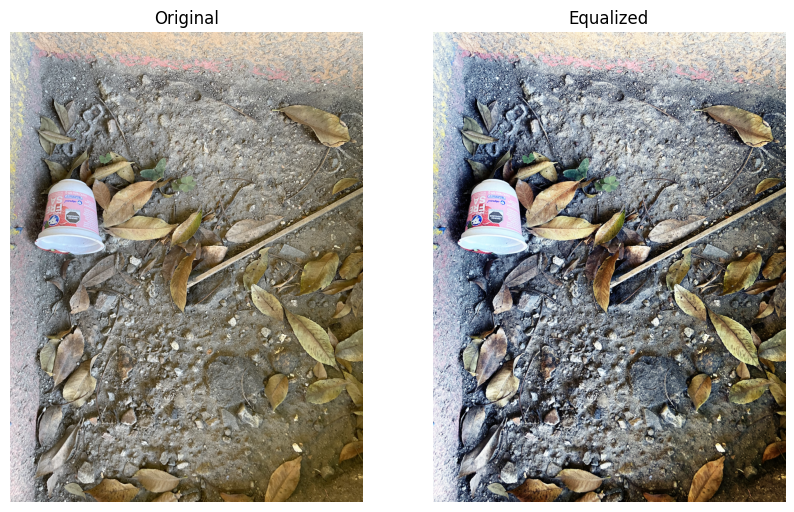

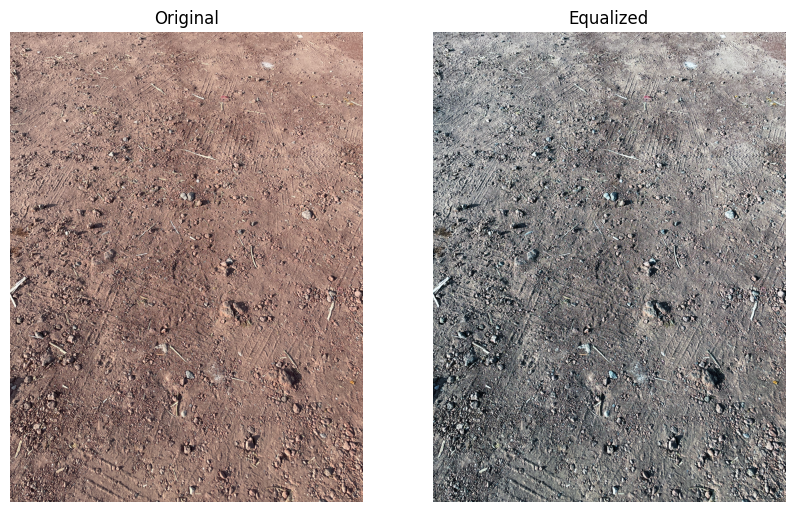

In [9]:
image_path = '/content/drive/MyDrive/Soil/iphone_images_test/sample2/IMG_7885.jpeg'

equalize_this(image_file=image_path, with_plot=True)

image_path_2 = '/content/drive/MyDrive/Soil/iphone_images_test/sample3/IMG_7893.jpeg'

equalize_this(image_file=image_path_2, with_plot=True)

## Padding

In [7]:
def get_pad_width(im, new_shape, is_rgb=True):
    # Calculate the padding needed for each dimension
    pad_diff = max(0, new_shape - im.shape[0]), max(0, new_shape - im.shape[1])
    t, b = math.floor(pad_diff[0] / 2), math.ceil(pad_diff[0] / 2)
    l, r = math.floor(pad_diff[1] / 2), math.ceil(pad_diff[1] / 2)

    # Define padding width based on RGB or grayscale
    if is_rgb:
        pad_width = ((t, b), (l, r), (0, 0))
    else:
        pad_width = ((t, b), (l, r))

    return pad_width

## **Pipeline**

In [ ]:
def preprocessing_pipeline(input_image):

    target_size = (224, 224)
    image = cv2.imread(input_image)

    # Step 1: Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Step 2: Apply Noise Reduction
    image = bilateral_denoise(image)

    # Step 3: Padding if needed
    if image.shape[0] < target_size[0] or image.shape[1] < target_size[1]:
        pad_width = get_pad_width(image, target_size[0])
        image = np.pad(image, pad_width, mode='constant', constant_values=0)

    # Step 4: Resize image to 224x224
    image = cv2.resize(image, target_size)

    # Step 5: Normalize pixel values to range [0, 1]
    image = image / 255.0

    return image


## One-hot encoding

In [ ]:
# Load images and labels
def load_images_from_folder(base_dir, labels):
    x_data = []
    y_data = []

    for label in labels:

        folder_path = os.path.join(base_dir, label)

        for img_name in os.listdir(folder_path):

            img_path = os.path.join(folder_path, img_name)
            img = preprocessing_pipeline(img_path)
            x_data.append(img)
            y_data.append(labels.index(label))

    return np.array(x_data), np.array(y_data)

In [ ]:
# Load training and testing data
x_train, y_train = load_images_from_folder(train_dir, labels)
x_test, y_test = load_images_from_folder(test_dir, labels)

In [ ]:
print("Training data shape:", x_train.shape)
print("Testing data shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Training data shape: (1215, 224, 224, 3)
Testing data shape: (340, 224, 224, 3)
y_train shape: (1215,)
y_test shape: (340,)


In [ ]:
from tensorflow.keras.utils import to_categorical

# One-hot encode labels
num_classes = len(labels)  # Number of unique classes
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

print("y_train shape after one-hot encoding:", y_train.shape)
print("y_test shape after one-hot encoding:", y_test.shape)


y_train shape after one-hot encoding: (1215, 4)
y_test shape after one-hot encoding: (340, 4)


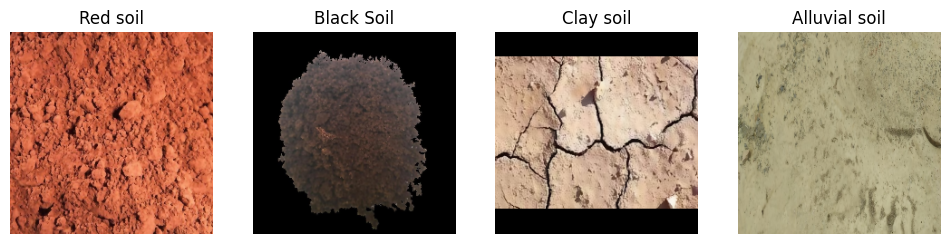

In [ ]:
num_samples = 8
sample_images = []

# Collect random sample images from each class
for label in classes:
    label_dir = os.path.join(train_dir, label)
    images = os.listdir(label_dir)
    # Randomly select an image from the class
    sample_image = os.path.join(label_dir, random.choice(images))
    sample_images.append((sample_image, label))


plt.figure(figsize=(12, 6))
for i, (image_path, label) in enumerate(sample_images[:num_samples]):
    img = preprocessing_pipeline(image_path)
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.show()

In [ ]:
y_train

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [ ]:
x_train, y_train = shuffle(x_train,y_train,random_state=101)
x_train.shape

(1215, 224, 224, 3)

# **Classification Models (3)**



**1.  DenseNet-121 with Fine-Tuning**

* DenseNet-121 model trained on ImageNet and further fine-tuned on the soil dataset for improved feature extraction.

<br>

**2.   DenseNet-121 Pre-trained (ImageNet Only)**

* The DenseNet-121 model using pre-trained weights from ImageNet without any additional training on the soil dataset.

<br>

**3.   VGG16 with Fine-Tuning**
* VGG16 model pre-trained on ImageNet, then fine-tuned on the soil dataset to adapt its learned features for soil classification.**










## **1. DenseNet-121 with Fine-Tuning**


In [ ]:
def build_model():
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(4, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.00005),
        metrics=['accuracy']
    )

    return model


In [ ]:
model = build_model()
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 7,041,604 (26.86 MB)

 Trainable params: 6,957,956 (26.54 MB)

 Non-trainable params: 83,648 (326.75 KB)

### Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 32

# Augmentation and normalization for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Normalization for validation data
validation_datagen = ImageDataGenerator(rescale=1./255)


train_ds = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)
validation_ds = validation_datagen.flow(x_test, y_test, batch_size=BATCH_SIZE)


### Model Training

In [ ]:
history = model.fit(
    train_ds,
    epochs = 10,
    validation_data = validation_ds,
)

model.save('/content/drive/MyDrive/Soil/soil_classificator_3.keras')

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 1031s 25s/step - accuracy: 0.4854 - loss: 1.3765 - val_accuracy: 0.1559 - val_loss: 1.4068
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 945s 25s/step - accuracy: 0.8362 - loss: 0.4772 - val_accuracy: 0.1971 - val_loss: 1.5331
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 944s 25s/step - accuracy: 0.8972 - loss: 0.2939 - val_accuracy: 0.1559 - val_loss: 1.6242
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 988s 25s/step - accuracy: 0.9297 - loss: 0.2116 - val_accuracy: 0.1647 - val_loss: 1.4965
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 983s 26s/step - accuracy: 0.9394 - loss: 0.1594 - val_accuracy: 0.3412 - val_loss: 1.4460
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1012s 25s/step - accuracy: 0.9530 - loss: 0.1314 - val_accuracy: 0.3118 - val_loss: 1.4690
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 990s 26s/step - accuracy: 0.9578 - loss: 0.1196 - val_accuracy: 0.1618 - val_loss: 1.4892
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 955s 25s/step - accuracy: 0.9637 - loss: 0.0951 - val_accuracy: 0.2559 - va

### **Performance Metrics**

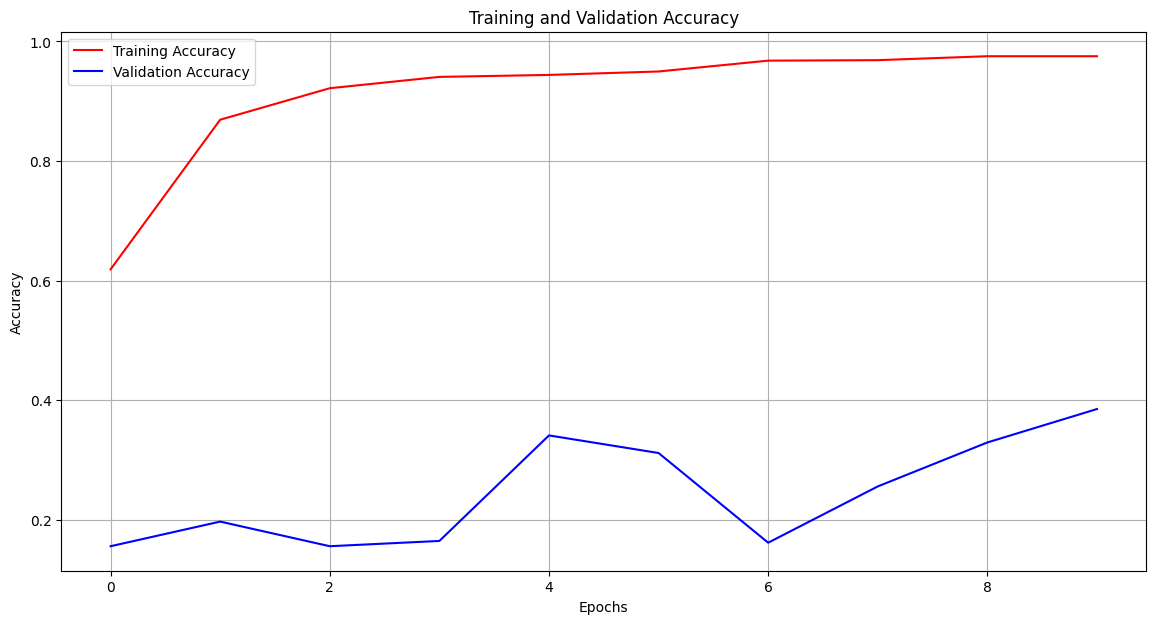

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

fig = plt.figure(figsize=(14, 7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

y_test_classes = np.argmax(y_test, axis=1)

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Classification Report:\n")
print(classification_report(y_test_classes, y_pred_classes, target_names=labels))


11/11 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step
               precision    recall  f1-score   support

Alluvial soil       0.31      0.83      0.45        53
   Black Soil       0.00      0.00      0.00       116
    Clay soil       0.83      0.88      0.85        65
     Red soil       0.83      0.99      0.90       106

     accuracy                           0.61       340
    macro avg       0.49      0.67      0.55       340
 weighted avg       0.46      0.61      0.51       340



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### **Results Interpretation**

**Fine-Tuned Model Performance:**

* The fine-tuned model achieved 61% accuracy and demonstrated good performance for Red Soil and Clay Soil, with F1-scores of 0.90 and 0.85, respectively.

* Challenges with Black Soil: The model failed to recognize Black Soil, indicating the need for data augmentation and better class balancing.

**Overfitting Concerns:**

* High recall but low precision for Alluvial Soil suggests overfitting, possibly due to class imbalance.


**Future Improvements**
* Applying regularization and adjusting class weights to improve the model’s generalization.

### Soil Prediction Example

In [ ]:
image_path="/content/drive/MyDrive/Soil/Dataset/Test/Red soil/Copy of image-red-soil-texture-260nw-243951718.png"

# Preprocess the image
preprocessed_image = preprocessing_pipeline(image_path)

# Expand dimensions for model input (1, 224, 224, 3)
model_input = np.expand_dims(preprocessed_image, axis=0)

In [ ]:
model_input.shape

(1, 224, 224, 3)

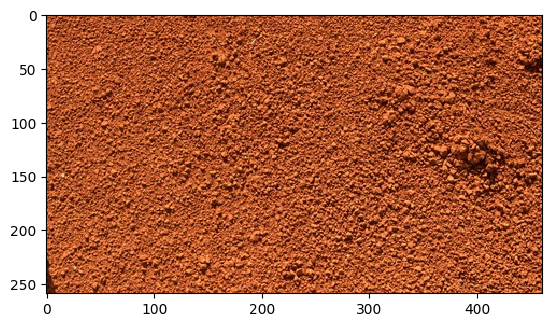

In [ ]:
from tensorflow.keras.preprocessing import image

img = image.load_img(image_path)
plt.imshow(img, interpolation='nearest')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Soil/soil_classificator_3.keras')

# Predict using the model
prediction = model.predict(model_input)

# Get the classification index of the higest probability
index = (np.argmax(prediction, axis=1))[0]


# Define soil types and their associated crops
soil={"Alluvial soil":"{This soil is suitable for corps: Rice, SugarCane, Maize, Cotton, Soyabean, Jute}",
      "Black Soil":"{This soil is suitable for corps: Wheat, Virginia, Jowar, Millets, Linseed, Castor, Sunflower}",
      "Clay soil":"{This soil is suitable for corps: Rice, Lettuce, Chard,Broccoli,Cabbage, Snap, Beans}",
      "Red soil":"{This soil is suitable for corps: Cotton, Pulses, Millets, OilSeeds, Potatoes}",

}

# List of labels corresponding to the model's output
labels = list(soil.keys())

# Predicted soil type
predicted_soil = labels[index]

if predicted_soil in soil:
    print("Soil Type:", predicted_soil)
    print(soil[predicted_soil])
else:
    print("Predicted soil type not recognized. Please check the model's output or the soil dictionary.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Soil Type: Red soil
{This soil is suitable for corps: Cotton, Pulses, Millets, OilSeeds, Potatoes}


## **2. DenseNet-121 without Fine-Tuning**

In [ ]:
from tensorflow.keras.applications import DenseNet121

def load_original_densenet121():
    model = DenseNet121(
        weights='imagenet',     # Load pre-trained weights from ImageNet
        include_top=True,       # Include the fully connected layers for classification
        input_shape=(224, 224, 3)  # Input shape suitable for ImageNet
    )

    return model


original_model = load_original_densenet121()

original_model.summary()

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_16         │ (None, 230, 230, 3)    │              0 │ input_layer_12[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_16[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_17         │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_17[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 8,062,504 (30.76 MB)

 Trainable params: 7,978,856 (30.44 MB)

 Non-trainable params: 83,648 (326.75 KB)

Found 340 images belonging to 4 classes.
11/11 ━━━━━━━━━━━━━━━━━━━━ 74s 6s/step


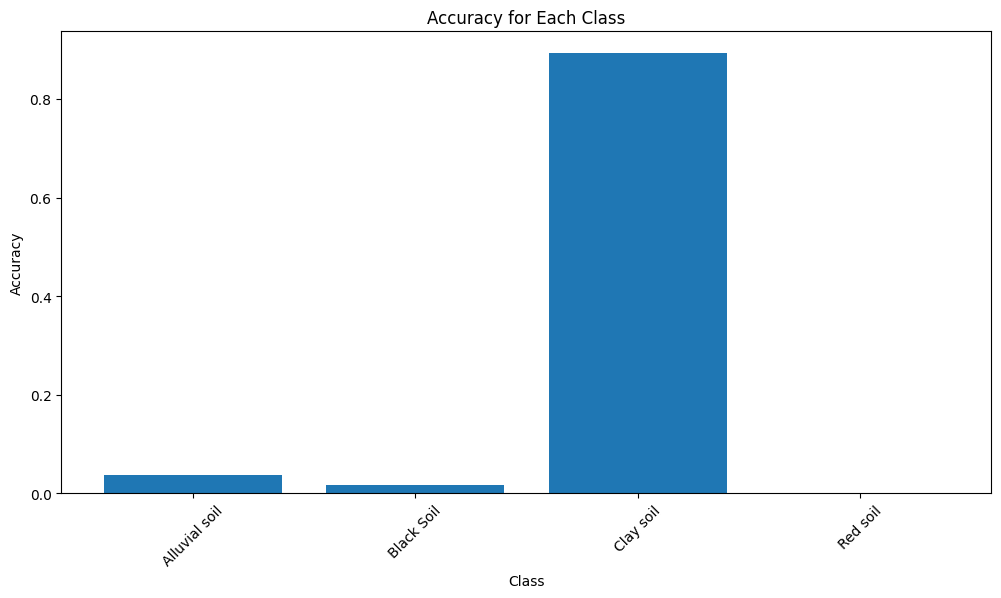

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import classification_report

# Step 1: Load the pre-trained DenseNet121 model and add custom layers
def build_model_with_custom_head():
    # Load DenseNet121 without the top layer
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    output = Dense(4, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.00005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Build model with custom head
model = build_model_with_custom_head()

# Step 2: Load test data
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Step 3: Predict with the model
predictions = model.predict(test_generator, verbose=1)

# Step 4: Convert predictions to labels and calculate classification report
true_labels = test_generator.classes
predicted_classes = np.argmax(predictions, axis=1)

labels = list(test_generator.class_indices.keys())

# Plotting per-label accuracy if you have specific classes to evaluate
def plot_per_class_accuracy(true_labels, predicted_classes, class_indices):
    unique_labels = np.unique(true_labels)
    accuracies = []

    for label in unique_labels:
        # Filter predictions for the current label
        label_indices = (true_labels == label)
        correct_predictions = np.sum(predicted_classes[label_indices] == label)
        total_predictions = np.sum(label_indices)
        label_accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
        accuracies.append(label_accuracy)

    classes = {v: k for k, v in class_indices.items()}
    class_names = [classes[label] for label in unique_labels]

    plt.figure(figsize=(12, 6))
    plt.bar(class_names, accuracies)
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Accuracy for Each Class')
    plt.xticks(rotation=45)
    plt.show()

# Step 5: Plot the Accuracy for Each Class
plot_per_class_accuracy(true_labels, predicted_classes, test_generator.class_indices)

### Performance Metrics

In [ ]:
print("\nClassification Report:")
print(classification_report(true_labels, predicted_classes, target_names=labels))


Classification Report:
               precision    recall  f1-score   support

Alluvial soil       0.11      0.04      0.06        53
   Black Soil       0.33      0.02      0.03       116
    Clay soil       0.18      0.89      0.31        65
     Red soil       0.00      0.00      0.00       106

     accuracy                           0.18       340
    macro avg       0.16      0.24      0.10       340
 weighted avg       0.17      0.18      0.08       340



### **Results**


* The pre-trained model without fine-tuning performs significantly worse compared to the model that underwent fine-tuning.

* This poor performance on the soil classification task can be attributed to the features learned from ImageNet, which do not translate effectively to differentiating between soil types.

* The low accuracy (18%) and low F1-scores across all classes suggest that feature extraction alone is insufficient without further adapting the model to the new task through fine-tuning.

<br>

**Imbalance in Performance Across Classes**:

* The model better identifies **Clay Soil** compared to other classes, possibly due to visual characteristics that align more closely with the features learned during pre-training.

* Red Soil and Black Soil are poorly predicted, likely because the learned features from ImageNet do not generalize well to these specific classes, leading to significant underperformance.

## **3. VGG16 with Fine-Tuning**

### Data augmentation

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Step 1: Load VGG16 base model
def build_vgg16_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    output = Dense(4, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.00005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Step 2: Create the model with VGG16 base
vgg16_model = build_vgg16_model()

# Step 3: Prepare the in-memory data using ImageDataGenerator
BATCH_SIZE = 32

# Augmentation and normalization for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Normalization for validation data
validation_datagen = ImageDataGenerator(rescale=1./255)


train_ds = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)
validation_ds = validation_datagen.flow(x_test, y_test, batch_size=BATCH_SIZE)

###Model Training

In [ ]:
history = vgg16_model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=10,
    verbose=1
)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 955s 25s/step - accuracy: 0.3191 - loss: 1.6424 - val_accuracy: 0.1559 - val_loss: 1.6618
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 952s 24s/step - accuracy: 0.3277 - loss: 1.5737 - val_accuracy: 0.1559 - val_loss: 1.6380
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 984s 24s/step - accuracy: 0.3229 - loss: 1.5665 - val_accuracy: 0.1559 - val_loss: 1.6174
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 981s 24s/step - accuracy: 0.3132 - loss: 1.5326 - val_accuracy: 0.1559 - val_loss: 1.5986
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 923s 24s/step - accuracy: 0.3411 - loss: 1.4778 - val_accuracy: 0.1559 - val_loss: 1.5844
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 916s 24s/step - accuracy: 0.3520 - loss: 1.5066 - val_accuracy: 0.1559 - val_loss: 1.5670
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 908s 24s/step - accuracy: 0.3201 - loss: 1.5201 - val_accuracy: 0.1559 - val_loss: 1.5534
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 933s 24s/step - accuracy: 0.3434 - loss: 1.5132 - val_accuracy: 0.

###Performance Metrics

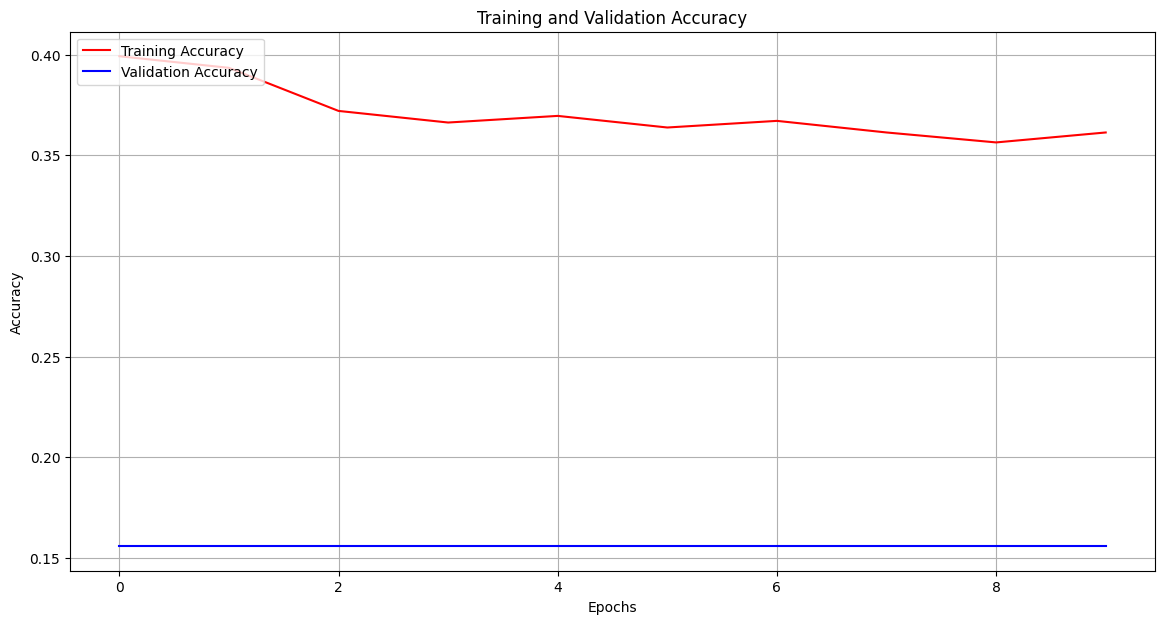

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


vgg16_model.save('/content/drive/MyDrive/Soil/vgg16_soil_classifier.keras')


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
fig = plt.figure(figsize=(14,7))

plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

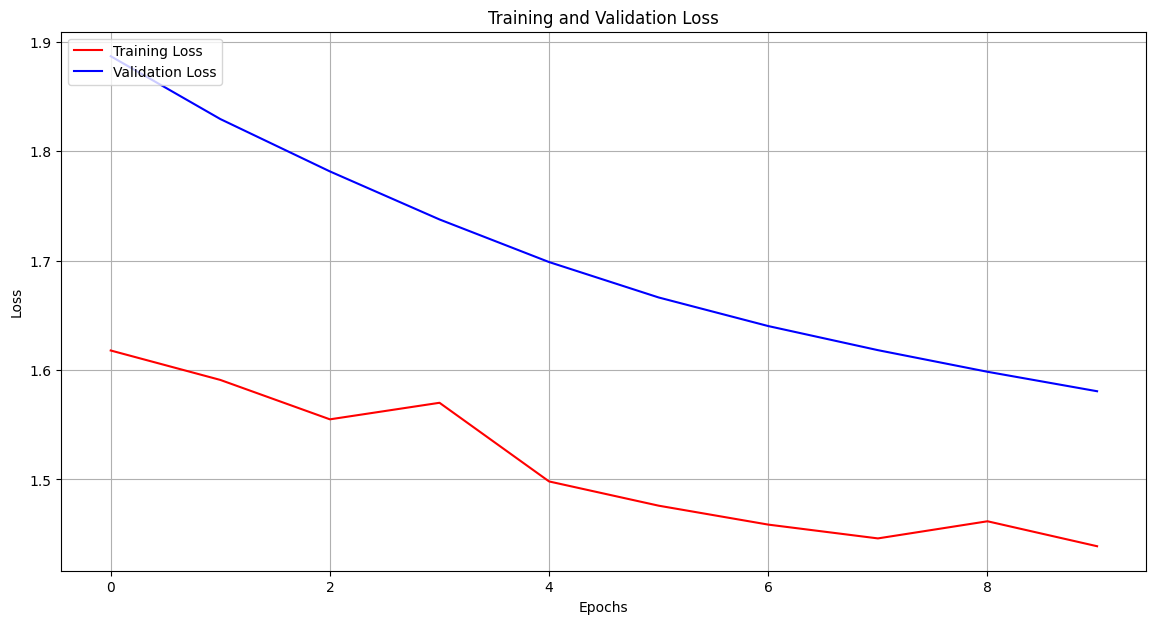

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

fig = plt.figure(figsize=(14, 7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

y_test_classes = np.argmax(y_test, axis=1)

y_pred = vgg16_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Classification Report:\n")
print(classification_report(y_test_classes, y_pred_classes, target_names=labels))

11/11 ━━━━━━━━━━━━━━━━━━━━ 213s 19s/step
Classification Report:

               precision    recall  f1-score   support

Alluvial soil       0.16      0.98      0.27        53
   Black Soil       0.40      0.03      0.06       116
    Clay soil       0.00      0.00      0.00        65
     Red soil       0.00      0.00      0.00       106

     accuracy                           0.16       340
    macro avg       0.14      0.25      0.08       340
 weighted avg       0.16      0.16      0.06       340



###**Results**

**1. Overfitting to Alluvial Soil:**

* The high recall (0.98) for Alluvial Soil and low precision (0.16) suggest that the model memorized features for this class, likely due to its abundance in the training dataset.

* This has led to overfitting, where the model overly predicts Alluvial Soil while not being effective in differentiating other classes.

**2. Failure to Learn Other Classes:**

* The model shows zero performance for Clay Soil and Red Soil, indicating that it has not learned useful features for these classes at all.

* The underrepresentation of these classes in the training set and the lack of relevant features may have contributed to this failure.

**3. Black Soil Issues:**

* Although precision for Black Soil is higher compared to other classes, the recall (0.03) is very poor, suggesting that the model rarely predicts this class correctly.

* The poor recall for Black Soil suggests that the model has difficulty recognizing this class, possibly because of feature overlap with other soils or due to insufficient training samples.




# **Conclusion**

##**Best Model: Fine-Tuned DenseNet121**

After evaluating multiple models, the **fine-tuned DenseNet121** (additionnal training) demonstrated the **best performance** for the soil classification task, achieving an accuracy of 61%. This model effectively learned relevant features for most soil classes, outperforming both the pre-trained model and the fine-tuned VGG16.

<br>

The fine-tuned DenseNet121 showed high precision and recall for Clay Soil and Red Soil, with F1-scores of 0.85 and 0.90, respectively. This indicates strong generalization for these classes after fine-tuning. However, it struggled with Black Soil, suggesting that further improvements in class balancing and augmentation could enhance performance.

<br>

---



<br>

The pre-trained model **without fine-tuning** (DenseNet121) performed poorly, with approximatly **18% accuracy**. This poor performance is attributed to the fact that the features learned from ImageNet do not transfer well to the specific soil classification problem without adaptation.

<br>

The **fine-tuned VGG16** also failed to perform well, achieving only **16% accuracy**. It exhibited overfitting to Alluvial Soil due to class imbalance, and failed to generalize to other classes (Clay Soil and Red Soil), which had zero F1-scores.


## **Possible Cause of Overfitting**

In [10]:
# Function to count images per class in a directory
def count_images_per_class(directory):
    class_counts = {}
    classes = os.listdir(directory)
    for label in classes:
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            num_images = len(os.listdir(label_dir))
            class_counts[label] = num_images
    return class_counts

# Count the images in train and test directories
train_counts = count_images_per_class(train_dir)
test_counts = count_images_per_class(test_dir)

# Display the number of images per class
print("Number of images per class in the training set:")
for label, count in train_counts.items():
    print(f"{label}: {count} images")

print("\nNumber of images per class in the test set:")
for label, count in test_counts.items():
    print(f"{label}: {count} images")

Number of images per class in the training set:
Red soil: 267 images
Black Soil: 228 images
Clay soil: 197 images
Alluvial soil: 523 images

Number of images per class in the test set:
Clay soil: 65 images
Red soil: 106 images
Alluvial soil: 53 images
Black Soil: 116 images


---



**Class Imbalance in the Training Set**:

* Alluvial Soil has 523 images, which is significantly more than the other classes.

* Red Soil has 267 images, Black Soil has 228 images, and Clay Soil has the fewest with 197 images.

* This uneven distribution means the model sees a lot more examples of Alluvial Soil during training, which could lead to bias toward this class.

* Classes with fewer images (**Clay Soil and Black Soil**) are underrepresented, making it harder for the model to learn the features specific to these classes. Tthe model might underfit these classes, failing to generalize well.



---


**Discrepancies Between Training and Test Sets:**

The training set and test set distributions are different.



*  Alluvial Soil has 523 images in training but only 53 images in testing.
*  Black Soil has 228 images for training but 116 in testing.
* The Clay Soil class has only 197 images for training but 65 for testing, indicating that 33% of all images of this type are in the test set, which makes it challenging for the model to learn effectively with fewer training samples.


Such discrepancies make it difficult for the model to generalize well because it hasn't seen a balanced or representative sample of the various classes during training.


# **Web Application (Gradio)**

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image
from tensorflow.keras.preprocessing import image

In [ ]:
model = load_model('/content/drive/MyDrive/Soil/soil_classificator_3.keras')

In [ ]:
import cv2
import numpy as np
from PIL import Image

def preprocessing_pipeline(input_image):
    """
    Preprocess the input image: Contrast enhancement, noise reduction, resizing, normalization.
    """
    target_size = (224, 224)

    # Enhance Contrast
    #input_image = equalize_this(image_file=input_image, with_plot=False)

    # Convert input to a NumPy array if it's a PIL image
    if isinstance(input_image, Image.Image):
        image = np.array(input_image)
    elif isinstance(input_image, np.ndarray):
        image = input_image  # If it's already a NumPy array
    else:
        raise ValueError("Input must be a PIL image or NumPy array")

    # Ensure the image is in RGB format
    if len(image.shape) == 3 and image.shape[-1] != 3:
        raise ValueError("Input image must have 3 channels (RGB)")

    # Apply Noise Reduction
    image = cv2.bilateralFilter(image, 9, 75, 75)

    # Resize image to 224x224
    image = cv2.resize(image, target_size)

    # Normalize pixel values to range [0, 1]
    image = image / 255.0

    return image


In [ ]:
def classify_image(image):
    # Preprocess the image
    preprocessed_image = preprocessing_pipeline(image)
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)  # Add batch dimension

    # Predict using the model
    predictions = model.predict(preprocessed_image)
    index = np.argmax(predictions, axis=1)[0]  # Get the class index
    probabilities = predictions[0]  # Probabilities for all classes

    # Define soil types and their associated crops
    soil = {
        "Alluvial soil": "Rice, SugarCane, Maize, Cotton, Soyabean, Jute",
        "Black Soil": "Wheat, Virginia, Jowar, Millets, Linseed, Castor, Sunflower",
        "Clay soil": "Rice, Lettuce, Chard, Broccoli, Cabbage, Snap Beans",
        "Red soil": "Cotton, Pulses, Millets, Oilseeds, Potatoes",
    }
    labels = list(soil.keys())

    # Get predicted soil type and recommended crops
    predicted_soil = labels[index]
    recommended_crops = soil.get(predicted_soil, "No crop recommendations available.")

    # Format probabilities for display
    probabilities_str = "\n".join(
        [f"{label}: {prob:.2f}" for label, prob in zip(labels, probabilities)]
    )

    return f"Soil Type: {predicted_soil}", f"Recommended Crops: {recommended_crops}", f"Class Probabilities:\n{probabilities_str}"


## Create Gradio Interface

In [ ]:
import gradio as gr

demo = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Textbox(label="Soil Type"),           # First output: Soil type
        gr.Textbox(label="Recommended Crops"),   # Second output: Recommended crops
        gr.Textbox(label="Class Probabilities"), # Third output: Probabilities
    ],
    title="Soil Type Classification and Crop Recommendation",
    description="Upload a soil image, and this app will classify the soil type, recommend suitable crops, and show prediction probabilities.",
)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://cdbbb47d92afd44bb4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://cdbbb47d92afd44bb4.gradio.live


##Lauch Application

In [ ]:
demo.launch(share=True, debug=True)